In [1]:
import tifffile
import numpy as np
import matplotlib.pyplot as plt
import distinctipy

In [29]:
log_dir = "/import/macyang_home1/share/ychenlp/ALL_LOG/Log_test_fpn_level_0_8_um_30_epoch/"
latent_map_64um = tifffile.imread(f"{log_dir}/latent_map.tif")

In [30]:
celltype_names = np.load("/import/macyang_home1/share/ychenlp/preprocessed/celltype_names.npy")
deconv_map = tifffile.imread(f"{log_dir}/deconv_beta_map.tif")

# Argmax along the z axis
deconv_map_sum = np.sum(deconv_map, axis=2)
zero_mask = deconv_map_sum == 0
argmax_deconv_map = np.argmax(deconv_map, axis=2) + 1
argmax_deconv_map[zero_mask] = 0

In [31]:
from tqdm.notebook import tqdm
X = []
celltypes = []
loc_x = []
loc_y = []
for i in tqdm(range(latent_map_64um.shape[0])):
    for j in range(latent_map_64um.shape[1]):
        latent = latent_map_64um[i, j]
        if latent.sum() == 0:
            continue
        celltype = celltype_names[argmax_deconv_map[i, j] - 1]
        celltypes.append(celltype)
        X.append(latent)
        loc_x.append(i)
        loc_y.append(j)

  0%|          | 0/791 [00:00<?, ?it/s]

In [32]:
import anndata as ad
import scanpy as sc
adata = ad.AnnData(np.array(X))
adata.obs["x"] = loc_x
adata.obs["y"] = loc_y
adata.obs["celltype"] = celltypes

In [33]:
adata.obsm["latent"] = adata.X

In [34]:
adata

AnnData object with n_obs × n_vars = 142612 × 128
    obs: 'x', 'y', 'celltype'
    obsm: 'latent'

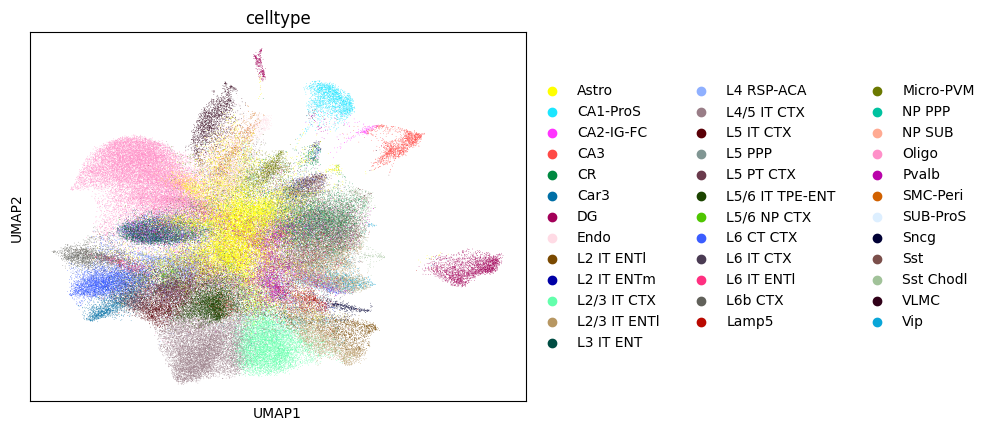

In [35]:
sc.pp.neighbors(adata, use_rep='latent', n_neighbors=10)
sc.tl.umap(adata)
sc.pl.umap(adata, color="celltype", color_map="rainbow")

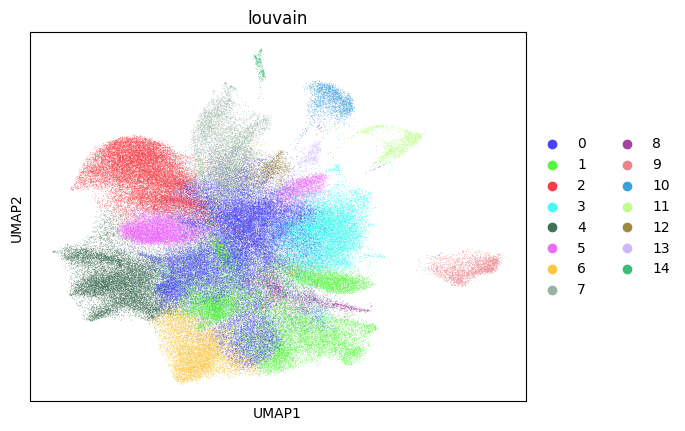

In [80]:
sc.tl.louvain(adata, resolution=0.3)
colors = distinctipy.get_colors(len(adata.obs["louvain"].unique()), pastel_factor=0.3, rng=10)
hex = [distinctipy.get_hex(c) for c in colors]
sc.pl.umap(adata, color="louvain", palette={str(i): hex[i] for i in range(len(hex))})

In [81]:
# Plot back
domain_map = np.zeros(latent_map_64um.shape[:2])

In [82]:
for i in tqdm(range(adata.shape[0])):
    x = adata.obs["x"][i]
    y = adata.obs["y"][i]
    domain_map[x, y] = int(adata.obs["louvain"][i])+1

  0%|          | 0/142612 [00:00<?, ?it/s]

/tmp/ipykernel_3808045/4037541735.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x = adata.obs["x"][i]
/tmp/ipykernel_3808045/4037541735.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = adata.obs["y"][i]
/tmp/ipykernel_3808045/4037541735.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  domain_map[x, y] = int(adata.obs["louvain"][i])+1


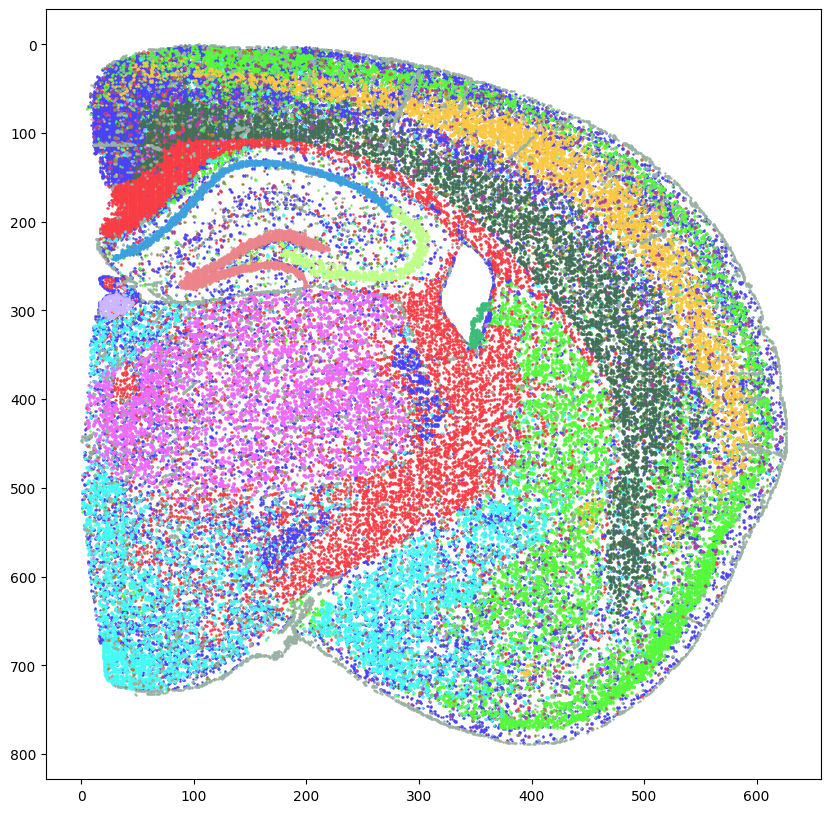

In [83]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
for i in range(len(colors)+1):
    if i == 0:
        continue
    ax.scatter(np.where(domain_map == i)[1], np.where(domain_map == i)[0], color=colors[i-1], s=0.5, label=f"Cluster {i-1}")
ax.invert_yaxis()